Found expert for TREX: reward=81.0
Found expert for CLASSIFIER_BC: reward=73.69999694824219
Found expert for IQL: reward=76.5
Found expert for GAIL: reward=79.19999694824219


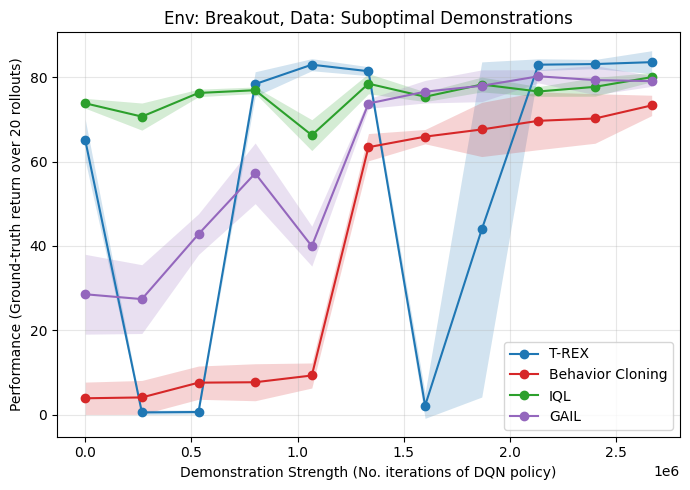

Expert Models:
  TREX: 81.0
  CLASSIFIER_BC: 73.69999694824219
  IQL: 76.5
  GAIL: 79.19999694824219


In [79]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np

INDEX_PATH = "../../comparison_outputs/index_breakout_subopt2.json"

# Load index
with open(INDEX_PATH, "r") as f:
    index = json.load(f)

# Known algos we want to plot (add more as needed)
ALGOS = ["TREX", "CLASSIFIER_BC", "IQL", "GAIL"]

# Storage
storages = {algo: {"strength": [], "mean": [], "std": []} for algo in ALGOS}

# Expert scores (no numeric suffix)
expert_scores = {algo: None for algo in ALGOS}

# Regex to extract trailing number from filenames
number_regex = re.compile(r".*?_(\d+)\.npz$")


for entry in index:
    algo = entry["algo"]            # e.g. "TREX", "CLASSIFIER_BC", "IQL", "GAIL"
    fname = entry["dataset_name"]   # e.g. "policy_params_6666752.npz"
    reward = entry["avg_reward"]
    std_reward = entry.get("std_reward")

    match = number_regex.match(fname)

    if match is None:
       # Expert model (no number in filename)
       if algo in expert_scores:
           expert_scores[algo] = reward
           print(f"Found expert for {algo}: reward={reward}")
       continue
    strength = int(match.group(1))
    # if fname == "noise_data.npz":
    #     continue
    # # Extract number
    # strength = float(fname.removeprefix("noise_data_noise").removesuffix(".npz"))
    if algo in storages:
        storages[algo]["strength"].append(strength)
        storages[algo]["mean"].append(reward)
        storages[algo]["std"].append(std_reward if std_reward is not None else 0.0)

# Convert to sorted curves
for algo, data in storages.items():
    sorted_pairs = sorted(zip(data["strength"], data["mean"], data["std"]))
    if sorted_pairs:
        s, m, st = zip(*sorted_pairs)
        storages[algo] = {
            "strength": np.array(s)[:-4],
            "mean": np.array(m)[4:],
            "std": np.array(st)[4:],
        }
    else:
        storages[algo] = {"strength": np.array([]), "mean": np.array([]), "std": np.array([])}

# --- Plot ---
plt.figure(figsize=(7, 5))
colors = {
    "TREX": "#1f77b4",          # blue
    "CLASSIFIER_BC": "#d62728", # red
    "IQL": "#2ca02c",           # green
    "GAIL": "#9467bd",          # purple
}
labels = {
    "TREX": "T-REX",
    "CLASSIFIER_BC": "Behavior Cloning",
    "IQL": "IQL",
    "GAIL": "GAIL",
}

for algo, data in storages.items():
    if data["strength"].size == 0:
        continue
    c = colors.get(algo, None)
    plt.plot(data["strength"], data["mean"], marker="o", label=labels.get(algo, algo), color=c)
    plt.fill_between(
        data["strength"],
        data["mean"] - data["std"],
        data["mean"] + data["std"],
        color=c,
        alpha=0.2,
        linewidth=0,
    )

#plt.xlabel(r"Applied Noise (Action-flip probability $\epsilon$)")
plt.xlabel(r"Demonstration Strength (No. iterations of DQN policy)")
plt.ylabel("Performance (Ground-truth return over 20 rollouts)")
plt.title("Env: Breakout, Data: Suboptimal Demonstrations")
plt.grid(True, alpha=0.3)
# plt.xlim([0,0.7 * 10e6])
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

# Print expert scores at the end
print("Expert Models:")
for algo, score in expert_scores.items():
    print(f"  {algo}: {score}")

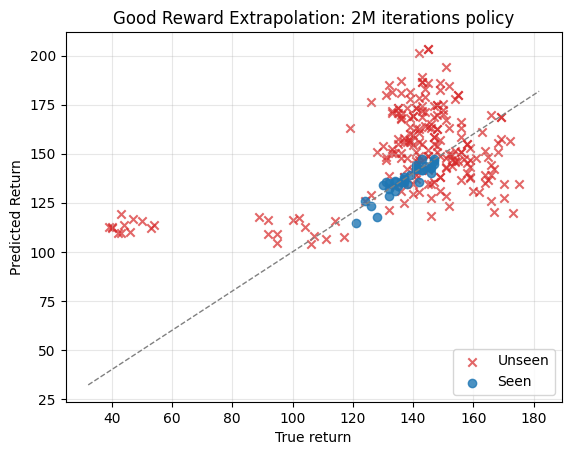

In [82]:
import json
with open('scripts/2M.json', 'r') as f:
    stats = json.load(f)

normalized_seen = stats["seen"]
normalized_unseen = stats["unseen"]

new = []
for i,n in enumerate(normalized_unseen):
    if i%8 == 0:
        new.append(n)
new2 = []
for i,n in enumerate(normalized_seen):
    if i%3 == 0:
        new2.append(n)

for subset, stats, color in [("Unseen", new, 'tab:red'),("Seen", new2, 'tab:blue')]:
    if subset == "Unseen":
        plt.scatter(*zip(*stats), label=subset, alpha=0.7, marker='o' if subset == "Seen" else 'x', color=color)

    else:
        plt.scatter(*zip(*stats), label=subset, alpha=0.8, marker='o' if subset == "Seen" else 'x', color=color)
lims = plt.xlim()
plt.plot(lims, lims, '--', color='gray', linewidth=1)
plt.title('Good Reward Extrapolation: 2M iterations policy')
plt.xlabel('True return')
plt.ylabel('Predicted Return')
plt.grid(True, alpha=0.3)
plt.legend(loc = "lower right")